# ERP Analysis Using MNE and Toeplitzlda for Auditory Word Stimuli

This notebook is based on anonymous patient data, stored on an external SSD.


#### Import Libraries

In [51]:
import mne
import re
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
import os
import warnings

import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from toeplitzlda.classification import ToeplitzLDA
from collections import defaultdict
import os

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
        

warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style('whitegrid')
mne.set_log_level('WARNING')

np.random.seed(42)

## Download and setup data

In [52]:
# Preparations

def load_and_preprocess_raw(header_file, s_freq=100, filter_band=(0.5, 40)):
    non_eeg_channels = ["EOGvu", "x_EMGl", "x_GSR", "x_Respi", "x_Pulse", "x_Optic"]
    raw = mne.io.read_raw_brainvision(header_file, misc=non_eeg_channels, preload=True)
    raw.set_montage("standard_1020")
    raw.filter(*filter_band, method="iir")
    raw.resample(sfreq=s_freq) 
    raw.pick_types(eeg=True)
    return raw 


def epoch_raw(raw, decimate=1):    # decimate=10 downsamples to 100Hz,
    target_ids = list(range(111, 117))
    non_target_ids = list(range(101, 107))
    event_id = {f"Word_{i-110}/Target": i for i in target_ids}
    event_id.update({f"Word_{i-100}/NonTarget": i for i in non_target_ids})
    evs, _ = mne.events_from_annotations(raw)

    epochs = mne.Epochs(raw=raw,
        events=evs,
        event_id=event_id,
        proj=False,
        tmax=1,
        preload=True,
        decim=decimate)      # Shape: (n_epochs, n_channels, n_times). E.g., you receive 6 epochs from 6 stimuli
    return epochs


def sort_key_by_block_and_run(path, pattern):
    match = pattern.search(path.name)
    if match:
        block_num = int(match.group(1))
        run_num = int(match.group(2))
        return (block_num, run_num)
    else:
        return (float("inf"), float("inf"))  
    

def get_jumping_means(epo, boundaries): 
    data = epo.get_data() # (n_epochs, n_channels, n_times) 

    n_epochs, n_channels, _ = data.shape
    n_bins = len(boundaries) - 1
    X = np.zeros((n_epochs, n_channels, n_bins)) 

    for i in range(n_bins): 
        idx = epo.time_as_index((boundaries[i], boundaries[i+1]))  
        X[:, :, i] = data[:, :, idx[0]:idx[1]].mean(axis=2)  
    
    return X



In [53]:
# Config
base_path = Path("/Volumes/Lexar/anonymized_P1-P10/P02")
filter_band = (0.5, 40)
session_id = "P02_S"

In [54]:
def load_sessions(base_path, session_id, filter_band):
    sessions = sorted(base_path.glob(f"{session_id}*"))

    data = defaultdict(lambda: defaultdict(dict))

    pattern = re.compile(r"Block(\d+)_Run(\d+)", re.IGNORECASE)

    for session in sessions:
        session_name = session.name
        header_files = sorted(
            session.glob("auditoryAphasia*.vhdr"),
            key=lambda p: sort_key_by_block_and_run(p, pattern)
        )

        print(f"Loading files: {header_files}")

        for header_file in header_files:
            match = pattern.search(header_file.name)
            if not match:
                print(f"Filename does not match expected pattern: {header_file.name}")
                continue

            block_num, run_num = int(match.group(1)), int(match.group(2))
            block_name = f"block_{block_num}"
            run_name = f"run_{run_num}"

            raw = load_and_preprocess_raw(header_file, filter_band=filter_band)
            data[session_name][block_name][run_name] = raw

    return data

data = load_sessions(base_path, session_id, filter_band)


Loading files: [PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block1_Run1.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block1_Run2.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block1_Run3.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block1_Run4.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block1_Run5.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block1_Run6.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block2_Run1.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block2_Run2.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block2_Run3.vhdr'), PosixPath('/Volumes/Lexar/anonymized_P1-P10/P02/P02_S03/auditoryAphasia_6D_350_Block2_Run4.vh

#### Inspect the dictionaries

In [7]:
raw = data['P4_S03']['block_1']['run_1']
raw_data = raw.get_data()  # shape: (n_channels, n_times)

print("min:", np.min(raw_data))
print("max:", np.max(raw_data))
print("mean:", np.mean(raw_data))
print("std:", np.std(raw_data))


min: -0.00019827563242833245
max: 0.0003871697817761583
mean: 9.394714072456812e-09
std: 3.2357031402748026e-05


In [8]:


print(data['P4_S03']['block_1']['run_1'])

# inspecting data
for session, blocks in data.items():
    print(f"Session: {session}")
    for block, runs in blocks.items():
        print(f"  Block: {block}")
        for run, raw in runs.items():
            print(f"    Run: {run}, Raw info: {raw.info['nchan']} channels, {raw.times[-1]:.2f}s")
            
# inspecting events           
for session, blocks in events.items():
    print(f"Session: {session}")
    for block, runs in blocks.items():
        print(f"  Block: {block}")
        for run, ev in runs.items():
            print(f"    Run: {run}, Events shape: {ev.shape if ev is not None else 'None'}")
            

# Inspecting event_ids
for session, blocks in event_ids.items():
    print(f"Session: {session}")
    for block, runs in blocks.items():
        print(f"  Block: {block}")
        for run, ev_id in runs.items():
            print(f"    Run: {run}, Event ID mapping:")
            for key, val in ev_id.items():
                print(f"      {key} -> {val}")



<RawBrainVision | auditoryAphasia_6D_350_Block1_Run1.eeg, 31 x 30230 (302.3 s), ~7.2 MiB, data loaded>
Session: P4_S03
  Block: block_1
    Run: run_1, Raw info: 31 channels, 302.29s
    Run: run_2, Raw info: 31 channels, 301.81s
    Run: run_3, Raw info: 31 channels, 302.27s
    Run: run_4, Raw info: 31 channels, 302.21s
    Run: run_5, Raw info: 31 channels, 302.79s
    Run: run_6, Raw info: 31 channels, 303.01s
  Block: block_2
    Run: run_1, Raw info: 31 channels, 302.75s
    Run: run_2, Raw info: 31 channels, 302.57s
    Run: run_3, Raw info: 31 channels, 303.01s
    Run: run_4, Raw info: 31 channels, 303.07s
Session: P4_S04
  Block: block_1
    Run: run_1, Raw info: 31 channels, 301.83s
    Run: run_2, Raw info: 31 channels, 301.71s
    Run: run_3, Raw info: 31 channels, 302.13s
    Run: run_4, Raw info: 31 channels, 302.31s
    Run: run_5, Raw info: 31 channels, 302.31s
    Run: run_6, Raw info: 31 channels, 303.19s
  Block: block_2
    Run: run_1, Raw info: 31 channels, 302.45

NameError: name 'events' is not defined

In [25]:
# inspecting shape of data and events
for session, blocks in data.items():
    print(f"\nSession: {session}")
    for block, runs in blocks.items():
        print(f"  Block: {block}")
        for run, raw in runs.items():
            raw_shape = raw.get_data().shape  # (n_channels, n_times)
            event_array = events[session][block][run]
            event_shape = event_array.shape if event_array is not None else "None"
            print(f"    Run: {run}")
            print(f"      Raw shape: {raw_shape} (channels, timepoints)")
            print(f"      Events shape: {event_shape} (n_events, 3)")



Session: P1_S03
  Block: block_1
    Run: run_1
      Raw shape: (31, 30080) (channels, timepoints)
      Events shape: (507, 3) (n_events, 3)
    Run: run_2
      Raw shape: (31, 30574) (channels, timepoints)
      Events shape: (548, 3) (n_events, 3)
    Run: run_3
      Raw shape: (31, 30554) (channels, timepoints)
      Events shape: (542, 3) (n_events, 3)
    Run: run_4
      Raw shape: (31, 29580) (channels, timepoints)
      Events shape: (506, 3) (n_events, 3)
    Run: run_5
      Raw shape: (31, 28194) (channels, timepoints)
      Events shape: (464, 3) (n_events, 3)
    Run: run_6
      Raw shape: (31, 30772) (channels, timepoints)
      Events shape: (542, 3) (n_events, 3)
  Block: block_2
    Run: run_1
      Raw shape: (31, 29754) (channels, timepoints)
      Events shape: (518, 3) (n_events, 3)
    Run: run_2
      Raw shape: (31, 30652) (channels, timepoints)
      Events shape: (548, 3) (n_events, 3)
    Run: run_3
      Raw shape: (31, 30634) (channels, timepoints)
  

#### Analysis


Session: P02_S03
P02_S03; clf=LDA ; train_size=60 ; AUC=0.529
P02_S03; clf=LDA ; train_size=120 ; AUC=0.509
P02_S03; clf=LDA ; train_size=180 ; AUC=0.517
P02_S03; clf=LDA ; train_size=240 ; AUC=0.542
P02_S03; clf=LDA ; train_size=300 ; AUC=0.494
P02_S03; clf=LDA ; train_size=390 ; AUC=0.504
P02_S03; clf=LDA ; train_size=510 ; AUC=0.526
P02_S03; clf=Shrinkage LDA ; train_size=60 ; AUC=0.521
P02_S03; clf=Shrinkage LDA ; train_size=120 ; AUC=0.513
P02_S03; clf=Shrinkage LDA ; train_size=180 ; AUC=0.514
P02_S03; clf=Shrinkage LDA ; train_size=240 ; AUC=0.554
P02_S03; clf=Shrinkage LDA ; train_size=300 ; AUC=0.547
P02_S03; clf=Shrinkage LDA ; train_size=390 ; AUC=0.555
P02_S03; clf=Shrinkage LDA ; train_size=510 ; AUC=0.578
P02_S03; clf=ToeplitzLDA ; train_size=60 ; AUC=0.539
P02_S03; clf=ToeplitzLDA ; train_size=120 ; AUC=0.512
P02_S03; clf=ToeplitzLDA ; train_size=180 ; AUC=0.516
P02_S03; clf=ToeplitzLDA ; train_size=240 ; AUC=0.538
P02_S03; clf=ToeplitzLDA ; train_size=300 ; AUC=0.529
P

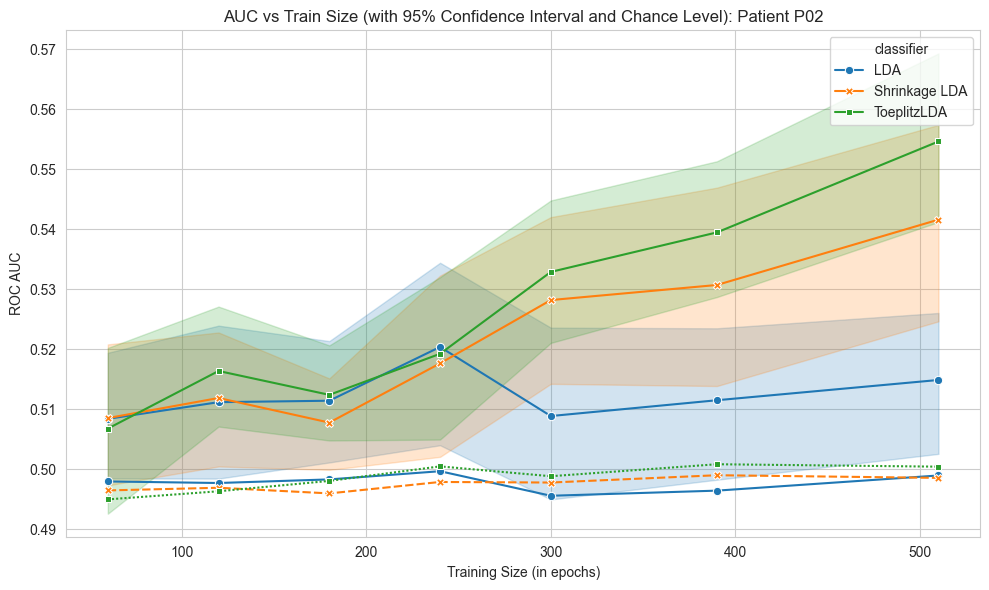

In [55]:
def load_and_concatenate_raws(blocks):
    all_runs = []
    for block_name in sorted(blocks.keys()):
        for raw in blocks[block_name].values():
            all_runs.append(raw.copy())
    return mne.concatenate_raws(all_runs)


def extract_features_and_labels(raw, tmin, tmax, clf_ival_boundaries):
    target_ids = list(range(111, 117))
    non_target_ids = list(range(101, 107))

    event_id = {f"Word_{i-110}/Target": i for i in target_ids}
    event_id.update({f"Word_{i-100}/NonTarget": i for i in non_target_ids})

    epochs = mne.Epochs(raw, event_id=event_id, tmin=tmin, tmax=tmax, decim=1,
                        baseline=None, preload=True, event_repeated='drop')

    y = epochs.events[:, 2]
    y_bin = np.array([1 if label in target_ids else 0 for label in y])

    X_features = get_jumping_means(epochs, clf_ival_boundaries)
    X_features = X_features.transpose(0, 2, 1).reshape(X_features.shape[0], -1)

    return X_features, y_bin


def run_classification(X, y, classifiers, train_sizes, n_test, session_name):
    results = []
    for clf_name, clf in classifiers.items():
        for train_size in train_sizes:
            if train_size + n_test > len(X):
                print(f"Skipping: train_size ({train_size}) + n_test ({n_test}) > data size ({len(X)})")
                continue

            X_train, y_train = X[:train_size], y[:train_size]
            X_test, y_test = X[-n_test:], y[-n_test:]

            pipeline = make_pipeline(StandardScaler(), clf)
            pipeline.fit(X_train, y_train)
            y_proba = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)

            results.append({
                'session': session_name,
                'classifier': clf_name,
                'train_size': train_size,
                'AUC': auc
            })

            print(f"{session_name}; clf={clf_name} ; train_size={train_size} ; AUC={auc:.3f}")
    return results

def run_ica_experiment(data, output_dir, classifiers, train_sizes, clf_ival_boundaries,
                       n_test, tmin=0.1, tmax=0.8):

    os.makedirs(output_dir, exist_ok=True)
    results_all = []

    for session_name, blocks in data.items():
        print(f"\nSession: {session_name}")
        raw_full = load_and_concatenate_raws(blocks)
        raw_copy = raw_full.copy()
        raw_copy.filter(l_freq=0.5, h_freq=40.0)

        X, y = extract_features_and_labels(raw_copy, tmin, tmax, clf_ival_boundaries)
        results = run_classification(X, y, classifiers, train_sizes, n_test, session_name)
        results_all.extend(results)

    df_results = pd.DataFrame(results_all)
    patient_id = next(iter(data))[:3]
    results_path = os.path.join(output_dir, f'no_ica_experiment_{patient_id}results.csv')
    df_results.to_csv(results_path, index=False)
    print(f"Results saved to: {results_path}")
    return df_results

def run_chance_level_experiment(data, output_dir, classifiers, train_sizes, clf_ival_boundaries,
                                n_test, tmin=0.1, tmax=0.8, seed=42):

    os.makedirs(output_dir, exist_ok=True)
    results_all = [] 

    for session_name, blocks in data.items():
        print(f"\nChance Level Session: {session_name}")
        raw_full = load_and_concatenate_raws(blocks)
        raw_copy = raw_full.copy()
        raw_copy.filter(l_freq=0.5, h_freq=40.0)

        X, y = extract_features_and_labels(raw_copy, tmin, tmax, clf_ival_boundaries)
        y_shuffled = shuffle(y, random_state=seed)

        results = run_classification(X, y_shuffled, classifiers, train_sizes, n_test,
                                     session_name=f"{session_name}_chance")
        results_all.extend(results)

    df_chance = pd.DataFrame(results_all)
    return df_chance


def run_permutation_test(data, output_dir, classifiers, train_sizes, clf_ival_boundaries,
                         n_test, n_permutations=100, tmin=0.1, tmax=0.8, seed=42):

    os.makedirs(output_dir, exist_ok=True)
    results_all = [] 

    rng = np.random.RandomState(seed)

    for session_name, blocks in data.items():
        print(f"\nPermutation Test Session: {session_name}")
        raw_full = load_and_concatenate_raws(blocks)
        raw_copy = raw_full.copy()
        #raw_copy.filter(l_freq=None, h_freq=16.0)

        X, y = extract_features_and_labels(raw_copy, tmin, tmax, clf_ival_boundaries)

        for perm in range(n_permutations):
            y_shuffled = shuffle(y, random_state=rng)
            results = run_classification(X, y_shuffled, classifiers, train_sizes, n_test,
                                         session_name=f"{session_name}_perm{perm:03d}")
            results_all.extend(results)

    df_permuted = pd.DataFrame(results_all)
    return df_permuted


def plot_auc_results(df_real, output_dir, df_chance=None, ci=95):
    plt.figure(figsize=(10, 6))

    df_real['source'] = 'real'
    sns.lineplot(
        data=df_real,
        x='train_size',
        y='AUC',
        hue='classifier',
        style='classifier',
        markers=True,
        dashes=False,
        ci=ci
    )

    if df_chance is not None:
        df_chance['source'] = 'chance'
        sns.lineplot(
            data=df_chance,
            x='train_size',
            y='AUC',
            hue='classifier',
            style='classifier',
            markers=True,
            dashes=True,
            ci=None,
            legend=False  
        )

    patient_label = df_real['session'].iloc[0].split('_')[0] if 'session' in df_real.columns else 'Unknown'
    
    plt.title(f'AUC vs Train Size (with 95% Confidence Interval and Chance Level): Patient {patient_label}')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training Size (in epochs)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()




# Run both experiments
output_dir = '/Volumes/Lexar/amplified_outputs'
train_sizes = [60, 120, 180, 240, 300, 390, 510]
clf_ival_boundaries=np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8])
classifiers = {
    'LDA': LDA(),
    'Shrinkage LDA': LDA(solver='lsqr', shrinkage='auto'),
    'ToeplitzLDA': ToeplitzLDA(n_channels=31)
}

df_real = run_ica_experiment(
    data=data,
    output_dir=output_dir,
    classifiers=classifiers,
    train_sizes=train_sizes,
    clf_ival_boundaries=clf_ival_boundaries,
    n_test=3000
)

df_chance = run_permutation_test(
    data=data,
    output_dir=output_dir,
    classifiers=classifiers,
    train_sizes=train_sizes,
    clf_ival_boundaries=clf_ival_boundaries,
    n_test=3000,
    n_permutations=5
)

df_real['source'] = 'real'
df_chance['source'] = 'chance'

plot_auc_results(df_real, output_dir, df_chance)
